### Data cleaning & transformation to abundance data

This notebook shows steps of data preparation performed in order to obtain `poetry_books_experiment_wide.csv` from `raw_data_poetry_1830_1850.csv`. 

In [ ]:
library(tidyverse)

#### Data cleaning

In [2]:
##### upload raw data #####
dat <- read.csv("../data/raw_data_poetry_1830_1850.csv") %>% 
  mutate_all(~na_if(., ""))

glimpse(dat)

Rows: 1,105
Columns: 44
$ X                  <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, …
$ id                 <int> 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17,…
$ poetry_prose       <chr> "v", "v", "v", "v", "v", "v", "v", "v", "v", "v", "…
$ book_type          <chr> "sep", "sep", "sep", "col", "sep", "col", "sep", "s…
$ genre              <chr> "nar", "lyr", "lyr", "lyr", "nar", "lyr", "nar", "n…
$ special_tag        <chr> NA, "unknown", "unknown", NA, NA, NA, NA, NA, NA, N…
$ author_sign        <chr> "Артемьев П.", NA, NA, "Батюшков К.", "Александр Б.…
$ author             <chr> "Артемьев П. А.", NA, NA, "Батюшков К.Н.", "Боде А.…
$ author_full_name   <chr> "Артемьев Павел Алексеевич", NA, NA, "Батюшков Конс…
$ title              <chr> "Страдалец: Повесть в стихах, взятая с истинного ра…
$ city               <chr> "М.", "СПб.", "СПб.", "СПб.", "СПб.", "М.", "СПб.",…
$ publisher          <chr> "Селивановского", "Крайя", "Акад. наук", "И. Глазун…
$ year          

In [3]:
##### Cleaning #####

# Filter books unknown everywhere
not_trusted <- dat %>% 
  filter(if_all(17:38, is.na)) %>% 
  pull(id)

dat <- dat %>% 
  filter(!id %in% not_trusted)


# Select df columns for ids & abundance data
dat <- dat %>% 
  mutate(id = row_number()) %>% 
  select(id, poetry_prose,  book_type, genre, special_tag, author_sign, 
         author, author_full_name, title, 
         city, publisher, year, 
         pages, size_cm, 
         RNL, RSL,
         CZ_SLK, EE_ester, FI_NL, LT_VUL, PL_BUW, PL_BN,
         SPbGU, US_Harvard, Rosanov)

In [5]:
#### drop prose, unknown & NA ####

# check grouping tag
unique(dat$book_type)
table(dat$book_type)

# check prose/verse tag
table(dat$poetry_prose)
unique(dat$poetry_prose)

# filter NA
dat <- dat %>% 
  filter(!is.na(poetry_prose))

[1] "sep" "col" "alm"


alm col sep 
112 398 564 


 pr   v 
112 961 

[1] "v"  "pr" NA

In [6]:
# check second grouping tag
unique(dat$genre)

# genre is NA for almanacs only
dat %>% 
  filter(is.na(genre)) %>% 
  select(book_type)

[1] "nar"      "lyr"      NA         "lyr; nar"

book_type
<chr>
alm
alm
alm
alm
alm
alm
alm
alm
alm


In [8]:
# unique(dat$special_tag)
# NA for special tag is ok

dat %>% 
  filter(is.na(special_tag))  %>% 
  nrow() # number of trusted books -- 939

# clean books tagged as doubles & others since they were not collected consecutively from all sources
tags_to_cln <- c("unknown", "double", "songs; double", "ortho; double", "songs; ukr lang", "ukr lang")

# books with mixed (nar & lyr) types - 
dat %>% 
  filter(genre == "lyr; nar") %>% 
  select(title)

## cleaning ###
dat <- dat %>% 
  filter(!special_tag %in% tags_to_cln) %>% 
  # clean if some almanacs tagged with genre (old ver of tagging)
  mutate(genre = ifelse(book_type == "alm", "", genre)) %>% 
  # tag mixed collections as narrative, since most of them follows the type: a narrative poem + some short poems
  mutate(genre = ifelse(str_detect(genre, ";|:"), "nar", genre)) %>% 
  # create a grouping column 
  mutate(group = paste(poetry_prose, book_type, genre, sep = "_")) %>% 
  mutate(group = ifelse(str_detect(group, "alm"), "almanac", group))

[1] NA      "ortho" "ukr"   "songs" "elegy"

[1] 939

title
<chr>


group,n
<chr>,<int>
almanac,106
pr_col_lyr,27
pr_sep_lyr,3
pr_sep_nar,1
v_col_lyr,319
v_col_nar,27
v_sep_lyr,275
v_sep_nar,260


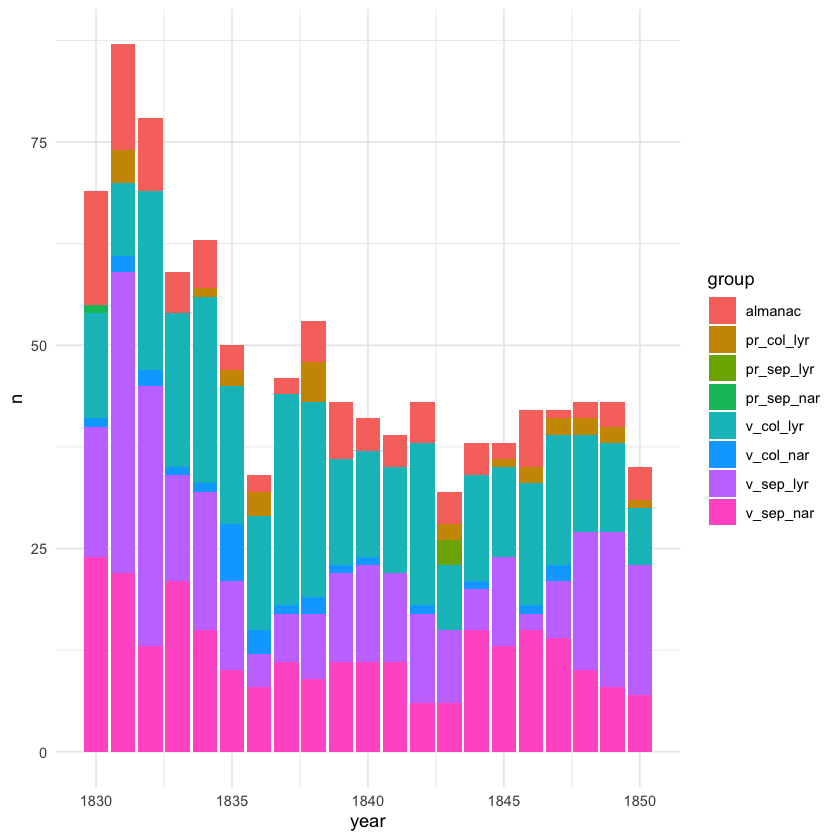

In [10]:
# check resulting data

dat %>% 
  group_by(group) %>% 
  count()

dat %>% 
  group_by(year, group) %>% 
  count() %>% 
  ggplot(aes(x = year, y = n, fill = group)) + geom_col() + theme_minimal()

In [11]:
# remove books containing prose (except for almanacs)

dat %>% 
  filter(!str_detect(group, "pr")) %>% 
  count() # 987 books tagged as not containing any prose OR being almanacs

# select only poetry & almanacs 
dat <- dat %>% 
  filter(!str_detect(group, "pr_")) %>% 
  mutate(group = str_remove_all(group, "^v_")) # clean group tag

table(dat$group)

n
<int>
987



almanac col_lyr col_nar sep_lyr sep_nar 
    106     319      27     275     260 

#### Data to 1 and 0

In [12]:
# check columns for each collection to have only NA or value of a book's presence
unique(dat$RNL) 
unique(dat$RSL)
unique(dat$Rosanov)
unique(dat$US_Harvard)
unique(dat$CZ_SLK)
unique(dat$PL_BUW)
unique(dat$PL_BN)
unique(dat$LT_VUL)
unique(dat$EE_ester)
unique(dat$FI_NL)
unique(dat$SPbGU)

[1] "004475784"   "004475787"   "004475875"   "004430931"   "005200270"  
  [6] "004431021"   "004431022"   "004475916"   "004430971"   "004431153"  
 [11] "004431064"   "004431132"   "004452744"   "005200283"   "004452730"  
 [16] "004430882"   "004475803"   "004430889"   "005203782"   "004430916"  
 [21] "004431061"   NA            "007105444"   "004430963"   "004559414"  
 [26] "004452747"   "005187240"   "004356811"   "004559374"   "004430879"  
 [31] "005208324"   "004431138"   "004431096"   "004476056"   "004431018"  
 [36] "004431005"   "004455038"   "004431091"   "004431040"   "004431131"  
 [41] "004431140"   "004452727"   "004431039"   "004431135"   "004475896"  
 [46] "004474474"   "004431104"   "001486384"   "004452736"   "005208291"  
 [51] "005208317"   "005208318"   "004358621"   "004559411"   "004431139"  
 [56] "004430625"   "004476584"   "004431429"   "004452780"   "004559498"  
 [61] "004431463"   "004476418"   "007189561"   "004452776"   "004431230"  
 [66] "004431384"   "004452751"   "005208336"   "004431196"   "004476358"  
 [71] "004431332"   "005200297"   "004431335"   "007198073"   "007198074"  
 [76] "004429831"   "004452763"   "004431450"   "004452777"   "004476582"  
 [81] "004356813"   "004431459"   "004476236"   "004431257"   "004431258"  
 [86] "004431259"   "004431260"   "006988334"   "004431249"   "004476323"  
 [91] "004358649"   "004358660"   "004452778"   "005187303"   "004358631"  
 [96] "005194144"   "005187302"   "004431284"   "004358641"   "004476608"  
[101] "004431494"   "004431708"   "005193277"   "004476993"   "005208688"  
[106] "004476653"   "004476359"   "004431671"   "004476807"   "004431619"  
[111] "004559638"   "004431644"   "004431755"   "004431756"   "004475522"  
[116] "004431765"   "004431894"   "004431642"   "004431646"   "004476785"  
[121] "005187311"   "004431552"   "004430051"   "004431891"   "004477383"  
[126] "004431744"   "004559685"   "004432014"   "004432127"   "004431807"  
[131] "004431803"   "004477056"   "005193300"   "004431851"   "004477094"  
[136] "004477096"   "004477097"   "005208415"   "004477099"   "004477071"  
[141] "004358782"   "004431935"   "004432015"   "004477383_2" "004477386"  
[146] "004477422"   "004432118"   "004432122"   "004477580"   "004432242"  
[151] "004431873"   "004356965"   "004356964"   "004452844"   "004432174"  
[156] "004477111"   "004431826"   "004432072"   "004432010"   "004477561"  
[161] "004431825"   "004452880"   "004432035"   "004356962"   "004452879"  
[166] "004432019"   "004477423"   "001417429"   "004452897"   "004432079"  
[171] "004356932"   "004477428"   "004432355"   "004477444"   "004432148"  
[176] "004432149"   "010350591"   "004477461"   "004452891"   "005193303"  
[181] "004432382"   "004432565"   "004432318"   "004477704"   "004432266"  
[186] "004477744"   "004432481"   "004430837"   "004477895"   "004559840"  
[191] "004432218"   "005208460"   "004432422"   "004559896"   "004432485"  
[196] "004477978"   "005200381"   "004432314"   "004432516"   "004452937"  
[201] "004452946"   "004432425"   "004432090"   "004452964"   "005187386"  
[206] "005208466"   "004476873"   "005187364"   "004477743"   "004432264"  
[211] "004452965"   "005204787"   "004358815"   "005187381"   "004358932"  
[216] "004432495"   "004432454"   "004432418"   "004432550"   "005208487"  
[221] "004432632"   "004478201"   "004358942"   "004453008"   "004432699"  
[226] "005208475"   "004478295"   "004478296"   "004432419"   "004358826"  
[231] "004359025"   "004478209"   "004478021"   "005200431"   "004478051"  
[236] "007094411"   "004432682"   "004432456"   "005200427"   "004358931"  
[241] "004358903"   "004432602"   "004359039"   "004432463"   "004559938"  
[246] "004559957"   "004559956"   "004432677"   "004432600"   "005208476"  
[251] "005208477"   "005208472"   "005208484"   "004359048"   "001815359"  
[256] "005200451"   "004432976"   "004478789"   "004432665"   "004478412"  
[261] "004432872"   "004432874"   "005200454"   "0

[1] "да" NA

[1] "259"  "295"  "338"  "341"  "600"  "711"  "714"  "774"  NA     "1472"
 [11] "1547" "1604" "1625" "1770" "1776" "1874" "1877" "1878" "1889" "1752"
 [21] "736"  "1911" "275"  "565"  "749"  "1001" "1062" "1380" "1381" "1866"
 [31] "1626" "314"  "639"  "241"  "1002" "251"  "375"  "599"  "719"  "989" 
 [41] "1623" "1655" "1887" "1283" "267"  "243"  "306"  "326"  "342"  "359" 
 [51] "459"  "718"  "1284" "1382" "1542" "1561" "1627" "1715" "1850" "1587"
 [61] "1234" "316"  "386"  "574"  "588"  "789"  "944"  "1218" "1296" "1606"
 [71] "327"  "1345" "1215" "400"  "499"  "575"  "705"  "1782" "1481" "563" 
 [81] "576"  "589"  "869"  "1104" "905"  "1548" "1695" "1063" "1909" "1219"
 [91] "672"  "1046" "1501" "1737" "1835" "1226" "344"  "276"  "316а" "536" 
[101] "926"  "1220" "1298" "1783" "1015" "1349" "1630" "748"  "812"  "641" 
[111] "972"  "1065" "1308" "1342" "1599" "1756" "1838" "1873" "218"  "339" 
[121] "540"  "906"  "927"  "1658" "1716" "1839" "1892" "260"  "527"  "1266"
[131] "1309" "1343" "1812" "1904" "216"  "343"  "486"  "487"  "928"  "1037"
[141] "1177" "1540" "1795" "1891" "1907" "239"  "416"  "784"  "1564" "360" 
[151] "418"  "537"  "556"  "1008" "1310" "1487" "1784" "642"  "1697" "1822"
[161] "1214" "1295" "717"  "838"  "470"  "548"  "1233" "1293" "1810" "1837"
[171] "953"  "1294" "305"  "1775" "1603" "1879" "455"  "1567" "229"  "580" 
[181] "971"  "1176" "1602" "1781" "1492" "734"  "1800" "1373" "368"  "374" 
[191] "274"  "1282" "1720" "1581" "970"  "1227" "636"  "996"  "637"  "1225"
[201] "1582" "911"  "458"  "1896" "1780" "1546" "230"  "307"  "1101" "1228"
[211] "727"  "1787" "1263" "1374" "1686" "1721" "713"  "1897" "1378" "917" 
[221] "1377" "809"  "561"  "1881"

[1] NA   "да"

[1] NA   "да"

[1] NA   "да"

[1] NA   "да"

[1] NA   "да"

[1] NA   "да"

[1] NA   "да"

[1] NA   "да"

In [13]:
# rewrite the table with 0 and 1
dat <- dat %>% 
  mutate(nlr = ifelse(!is.na(RNL), 1, 0)) %>% 
  mutate(rsl = ifelse(!is.na(RSL), 1, 0)) %>% 
  mutate(rozanov = ifelse(!is.na(Rosanov), 1, 0)) %>% 
  mutate(us_harvard = ifelse(!is.na(US_Harvard), 1, 0)) %>% 
  mutate(cz_slk = ifelse(!is.na(CZ_SLK), 1, 0)) %>% 
  mutate(lt_vul = ifelse(!is.na(LT_VUL), 1, 0)) %>% 
  mutate(pl_bn = ifelse(!is.na(PL_BN), 1, 0)) %>% 
  mutate(pl_buw = ifelse(!is.na(PL_BUW), 1, 0)) %>% 
  mutate(ee_ester = ifelse(!is.na(EE_ester), 1, 0)) %>% 
  mutate(fi_sl = ifelse(!is.na(FI_NL), 1, 0)) %>% 
  mutate(spbgu = ifelse(!is.na(SPbGU), 1, 0)) %>% 
  select(-c(RNL:Rosanov)) 


glimpse(dat)

Rows: 987
Columns: 26
$ id               <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…
$ poetry_prose     <chr> "v", "v", "v", "v", "v", "v", "v", "v", "v", "v", "v"…
$ book_type        <chr> "sep", "col", "sep", "col", "sep", "sep", "sep", "col…
$ genre            <chr> "nar", "lyr", "nar", "lyr", "nar", "nar", "nar", "lyr…
$ special_tag      <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ author_sign      <chr> "Артемьев П.", "Батюшков К.", "Александр Б.", "Борозд…
$ author           <chr> "Артемьев П. А.", "Батюшков К.Н.", "Боде А.К.", "Боро…
$ author_full_name <chr> "Артемьев Павел Алексеевич", "Батюшков Константин Ник…
$ title            <chr> "Страдалец: Повесть в стихах, взятая с истинного расс…
$ city             <chr> "М.", "СПб.", "СПб.", "М.", "СПб.", "М.", "СПб.", "СП…
$ publisher        <chr> "Селивановского", "И. Глазунова", "Крайя", "Семена", …
$ year             <int> 1834, 1834, 1834, 1834, 1834, 1834, 1834, 1834, 1834,…
$ pages           

In [14]:
# select columns
biblio_wide <- dat %>% 
  select(id, group, author_sign, author_full_name, title, 
         city, publisher, year, pages, size_cm, 
         nlr, rsl, rozanov, us_harvard, cz_slk, lt_vul, pl_bn, pl_buw, ee_ester, fi_sl, spbgu)

# add available data on collection size in Russian (books issued in 1830-1850)
counts <- biblio_wide %>% 
  summarise_at(vars(nlr:spbgu), sum)


total <- list(58000, 28000, 1914, 1887, 4222, 4423, 1450, 827, 3212, 3593, 96)
counts[nrow(counts) + 1,] <- total

# total number of poetry books VS collection size (not applicable to rozanov & spbgu)
counts

,nlr,rsl,rozanov,us_harvard,cz_slk,lt_vul,pl_bn,pl_buw,ee_ester,fi_sl,spbgu
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,924,529,230,167,185,22,19,18,58,217,93
2,58000,28000,1914,1887,4222,4423,1450,827,3212,3593,96


In [15]:
# count total number of occurances for each book
biblio_wide <- biblio_wide %>% 
  rowwise() %>% mutate(n_total = sum(c_across(11:21)))

#glimpse(biblio_wide)

biblio_wide %>% 
  filter(n_total == 0) %>% 
  nrow # at least 20 books mentioned in Smirdin's col. are completely lost

# final ver of data with books found at least in one collection
# 967 books
biblio_wide <- biblio_wide %>% 
  filter(!n_total == 0)

table(biblio_wide$group)

# write.csv(biblio_wide, file = "data/poetry_books_experiment_wide.csv")

[1] 20


almanac col_lyr col_nar sep_lyr sep_nar 
    101     313      27     269     257 

#### Write data for experiment

In [16]:
# create ids w/ groups
to_exp <- biblio_wide %>% 
  mutate(work = paste0(group, "__", year, "_", id, "_", author_sign, "_", title)) %>% 
  select(work,
         nlr:spbgu)

# pivot data to long format
to_exp_long <- to_exp %>% 
  pivot_longer(!work, names_to = "collection", values_to = "count") %>% 
  # leave only existing copies
  filter(count != 0) %>% 
  # detach groups to separate column
  separate(work, into = c("group", "work"), sep = "__") %>% 
  select(group, work, collection)

head(to_exp_long)

group,work,collection
<chr>,<chr>,<chr>
sep_nar,"1834_1_Артемьев П._Страдалец: Повесть в стихах, взятая с истинного рассказа родственников страдальца",nlr
sep_nar,"1834_1_Артемьев П._Страдалец: Повесть в стихах, взятая с истинного рассказа родственников страдальца",rsl
sep_nar,"1834_1_Артемьев П._Страдалец: Повесть в стихах, взятая с истинного рассказа родственников страдальца",rozanov
col_lyr,1834_2_Батюшков К._Сочинения в прозе и стихах Константина Батюшкова. Ч. 2. Стихотворения,nlr
col_lyr,1834_2_Батюшков К._Сочинения в прозе и стихах Константина Батюшкова. Ч. 2. Стихотворения,rsl
col_lyr,1834_2_Батюшков К._Сочинения в прозе и стихах Константина Батюшкова. Ч. 2. Стихотворения,rozanov


#### Main experiment data tables

In [17]:
#### Lyric collections ####

col_lyr <- to_exp_long %>% 
  filter(group == "col_lyr") %>% 
  select(work, collection)

col_lyr %>% 
  group_by(work) %>% 
  count(sort = T) %>% 
  head(20)

length(unique(col_lyr$work))

write.csv(col_lyr, file = "../data/copia_experiment/Collections_lyric.csv")

work,n
<chr>,<int>
1834_2_Батюшков К._Сочинения в прозе и стихах Константина Батюшкова. Ч. 2. Стихотворения,9
1835_73_Баратынский Е._Сочинения Е. Баратынского: В 2 ч.,9
1830_1071_Крылов И._Басни Ивана Крылова: В 8 книгах,8
"1832_1045_Катенин П., Голицын Н._Сочинения и переводы в стихах Павла Катенина, с приобщение нескольких стихотворения князя Николая Голицына : Ч. 1-2",8
1832_782_Давыдов Д.В._Стихотворения Дениса Давыдова,8
1833_1044_Козлов И._Собрание стихотворений Ивана Козлова : Ч. 1-2,8
1833_778_Кульман Е.Б._Пиитические опыты Елисаветы Кульман: В 3 ч.,8
1831_795_Маркевич Н._Украинские мелодии. Соч. Ник. Маркевича,7
"1831_921_Масальский К._Сочинения, переводы и подражания в стихах Константина Масальского",7


[1] 313

In [18]:
#### Separate lyric poems ####

sep_lyr <- to_exp_long %>% 
  filter(group == "sep_lyr") %>% 
  select(work, collection)

length(unique(sep_lyr$work))

sep_lyr %>% 
  count(work, sort = T) %>% 
  head(20)

write.csv(sep_lyr, file = "../data/copia_experiment/Separate_lyric.csv")

[1] 269

work,n
<chr>,<int>
1831_990_Жуковский В._Русская слава : Стихотворение,5
1832_882_Соколовский В._Мироздание [Опыт духовного стихотворения]. Изд. 1-е,5
"1831_1039_Фомин Н._Отец Царства Русского, или Неделя пребывания великого монарха Николая I в печальной Москве / Взятое из истин. происшествия Николаем Фоминым",4
"1831_1043_Жуковский В., Пушкин А._На взятие Варшавы : Три стихотворения",4
1831_974_NA_Шесть элегических стихотворений,4
1833_1054_Поднебесный М._Прогулка на Выставке российских изделий в Санкт-Петербурге 1833 года : [стихотворение],4
1838_208_Доброхотов Ф._Взгляд на поэзию Феофила Доброхотова,4
1840_300_Данков И.И._Могила боярина Артамона Сергеевича Матвеева: [Стихотворение],4
"1848_624_Вяземский П._Святая Русь : Стихотворение К[н]. П. Вяземского, изданное в пользу Второй Адмиралтейской школы",4


In [19]:
#### Separate narrative poems ####

sep_nar <- to_exp_long %>% 
  filter(group == "sep_nar") %>% 
  select(work, collection)

length(unique(sep_nar$work))

sep_nar %>% 
  count(work, sort = T) %>% 
  head(20)

#write.csv(sep_nar, file = ".../data/copia_experiment/Separate_narrative.csv")

[1] 257

work,n
<chr>,<int>
1830_1000_Слепушкин Ф._Четыре времени года Русского Поселянина : Сельская поэма Федора Слепушкина,8
"1830_997_Глинка С._Карелия, или заточение Марфы Иоанновны Романовой, описательное стихотворение : В 4 ч.",7
"1832_810_Марков_Мятежники. Повесть, взятая из войны с Польскими мятежниками. Соч. Маркова",7
1837_167_Подолинский А._Смерть Пери,7
1838_223_Бернет Е._Елена: Поэма,7
1830_933_Козлов И._Безумная : Русская повесть в стихах,6
1830_946_Подолинский А._Нищий,6
"1830_957_Масальский К._Терпи казак, атаман будешь : Стихотворная повесть / Изд. 3-е",6
1831_944_Вельтман А._Муромские леса : Повесть в стихах,6


In [20]:
#### Collections narrative ####

col_nar <- to_exp_long %>% 
  filter(group == "col_nar") %>% 
  select(work, collection)

length(unique(col_nar$work))

col_nar %>% 
  count(work, sort = T) %>% 
  head(20)

write.csv(col_nar, file = "../data/copia_experiment/Collections_narrative.csv")

[1] 27

work,n
<chr>,<int>
1831_964_Жуковский В._Баллады и повести : В 2 ч.,7
1835_82_Пушкин А.С._Поэмы и повести Александра Пушкина. Ч. 2.,7
1836_144_Подолинский А._Повести и мелкие стихотворения А. Подолинского. Ч. 1.,7
1835_81_Пушкин А.С._Поэмы и повести Александра Пушкина. Ч. 1.,6
1838_200_Павлов М._Повести в стихах,6
1832_803_Полежаев А._Эрпели и Чир-Юрт. Две поэмы А. Полежаева,5
1835_92_Жуковский В.А._Стихотворения Василья Жуковского: В 8 ч. / Изд. 4-е. Т. 1. Орлеанская дева; лирические стихотворения,5
1835_94_Жуковский В.А._Стихотворения Василья Жуковского: В 8 ч. / Изд. 4-е. Т. 3. Баллады,5
1835_95_Жуковский В.А._Стихотворения Василья Жуковского: В 8 ч. / Изд. 4-е. Т. 4. Баллады,5


In [21]:
#### Almanacs ####

alm <- to_exp_long %>% 
  filter(group == "almanac") %>% 
  select(work, collection)

length(unique(alm$work))

alm %>% 
  count(work, sort = T) %>% 
  head(20)

write.csv(alm, file = "../data/copia_experiment/Almanacs.csv")

[1] 101

work,n
<chr>,<int>
"1839_265_Кукольник Н. (изд.)_Новогодник, собрание сочинений в прозе и стихах, современных русских писателей изданный Н. Кукольником",6
"1841_371_NA_Русская беседа : Собр. соч. рус. литераторов, изд. в пользу А.Ф. Смирдина: В 3 т. Т. 1",6
"1841_372_NA_Русская беседа : Собр. соч. рус. литераторов, изд. в пользу А.Ф. Смирдина: В 3 т. Т. 2",6
"1832_768_Эртель В., Глебов А. (изд.)_Русский альманах на 1832 и 1833 годы",5
1833_765_NA_Новоселье: [альманах]. Часть 1,5
1834_50_NA_Новоселье. Ч. 2,5
1840_331_Владиславлев В._Утренняя заря Альманах Владиславлева на 1840 год. 2-й год,5
1841_341_Владиславлев В.А._Утренняя заря Альманах Владиславлева на 1841 год. 3-й год,5
"1842_414_NA_Русская беседа : Собр. соч. рус. литераторов, изд. в пользу А.Ф. Смирдина: В 3 т. Т. 3",5


In [ ]:
#### Additional experiment ####
#### year + genre grouping ####

to_exp_years <- biblio_wide %>% 
  mutate(year_group = floor(year/5)*5) %>% 
  mutate(year_group = ifelse(year_group == 1850, 1845, year_group)) %>% 
  mutate(work = paste0(group, "_", year_group, "____", id, "_", author_sign, "_", title)) %>% 
  select(work,
         nlr:spbgu)


to_exp_years_long <- to_exp_years %>% 
  pivot_longer(!work, names_to = "collection", values_to = "count") %>% 
  filter(count != 0) %>% 
  separate(work, into = c("group", "work"), sep = "____") %>% 
  select(group, work, collection)

glimpse(to_exp_years_long)

to_exp_years_long %>% 
  group_by(group) %>% 
  count()

x <- NULL
group <- NULL

for (i in 1:length(unique(to_exp_years_long$group))) {
  
  group_i <- unique(to_exp_years_long$group)[i]
  
  x <- to_exp_years_long %>% 
    filter(group == group_i) %>% 
    select(work, collection)
  
  write.csv(x, file = paste0("data/copia_experiment/addition/", group_i, ".csv"))
}